Runs two basic convolutional networks on the pilot dataset.

### Things to do next
- Figure out how to do regression (see below).
- Figure out how to do multitask learning (i.e. try to predict the different reps and different genes).
- Run on the scale up dataset.
- Read up on the "Interpreting a DragoNN model using filter visualization" and "Interpreting data with a DragoNN model" in the Dragonn tutorial.

### Installing Dragonn
- Clone from https://github.com/kundajelab/dragonn
- ```python setup.py```
    - I needed to ```brew install geos```

In [1]:
from dragonn import models

from collections import OrderedDict
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using Theano backend.
/Users/andrewlamb/anaconda/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Read in the pilot data.
- Samples are sequences that will be one hot encoded
- Try and predict the normalized values. **I couldn't figure out how to do regression with Dragonn, so I just rounded the values to 0 or 1 based on the median.**

In [2]:
key_to_seq = OrderedDict()

with open("../data/Pilot_counts_sequences/PilotDesign.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        key_to_seq[key] = seq
        
pprint(key_to_seq.items()[:5])

[('high_0_0',
  'CTAGGTGGATACAGGTTTCTTCTGAGGGCCAAAGCCTGGGCCCTATTGCTCTGGTTGCCATGGCTGTTTCTTTTCTCTCCTTTCCTTTGATACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAA'),
 ('high_0_1',
  'AAAGCCTGGGCCCTATTGCTCTGGTTGCCATGGCTGTTTCTTTTCTCTCCTTTCCTTTGATACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAAC'),
 ('high_0_2',
  'TGGCTGTTTCTTTTCTCTCCTTTCCTTTGATACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAACCTTTAACAATGAATACCATTCATTATGTAT'),
 ('high_0_3',
  'TACATTAGCTATTAGCTTACGTAATCCTCTCACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAACCTTTAACAATGAATACCATTCATTATGTATTTGCTTAATGATACAAAGGCATTGTTTGCT'),
 ('high_0_4',
  'CACCGGTGGATGTTCCCATTCAAAAGGCAAAAAAAAAGTTATATTGCTAAGTAACCTTTAACAATGAATACCATTCATTATGTATTTGCTTAATGATACAAAGGCATTGTTTGCTCTATTGCAGGTGATAACAGCAGATCAAAGA')]


In [3]:
key_to_normalized_K562_Rep1 = {}
key_to_normalized_K562_Rep2 = {}

with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep1_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep1[key] = val
            
with open("../data/Pilot_normalized/K562/tablenorm_recenterends_K562_Rep2_20.txt") as f:
    for line in f:
        parts = line.strip().split()
        
        for i, norm in enumerate(parts[1:]):
            key = "{}_{}".format(parts[0], i)
            val = float(norm)
            key_to_normalized_K562_Rep2[key] = val

# Check that the sequence and value keys line up.
assert set(key_to_normalized_K562_Rep1.keys()) == set(key_to_seq.keys())
assert set(key_to_normalized_K562_Rep2.keys()) == set(key_to_seq.keys())

In [4]:
# One hot encode DNA sequences the standard way.
def one_hot_encode_seq(seq):
    bases = ['A', 'T', 'C', 'G']
    # Gotta be ready for when we discover a new base.
    result = np.zeros((4, len(seq)))
    
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1

    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, 4, len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
    
    return result

In [5]:
X = seqs_to_encoded_matrix(key_to_seq.values())

In [6]:
# Just round to the median, to make this a classification task for now.
K562_Rep1_median = np.median(key_to_normalized_K562_Rep1.values())
K562_Rep1_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep1[key] > K562_Rep1_median, 
        key_to_seq.keys()
    )
).reshape(-1, 1)

K562_Rep2_median = np.median(key_to_normalized_K562_Rep2.values())
K562_Rep2_y = np.array(
    map(
        lambda key: key_to_normalized_K562_Rep2[key] > K562_Rep2_median, 
        key_to_seq.keys()
    )
).reshape(-1, 1)

# TODO: Figure out how to do multitask.
# y = np.hstack([K562_Rep1_y, K562_Rep2_y])
y = K562_Rep1_y

In [7]:
# Just take the last 100 to be the validation set.
X_train = X[:-100,:,:,:]
y_train = y[:-100,:]

X_valid = X[-100:,:,:,:]
y_valid = y[-100:,:]

Start with the model used in the Dragonn tutorial. Train and plot the train and validation loss.

In [8]:
model = models.SequenceDNN(
    seq_length=X_train.shape[3],
    num_filters=[1],
    conv_width=[45],
    pool_width=45
)

In [9]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.6932	Balanced Accuracy: 50.90%	 auROC: 0.530	 auPRC: 0.528	 auPRG: 0.051
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|1.2%	 Num Positives: 1066	 Num Negatives: 1084
Valid Loss: 0.7101	Balanced Accuracy: 56.04%	 auROC: 0.489	 auPRC: 0.657	 auPRG: -0.118
	Recall at 5%|10%|20% FDR: 10.2%|10.2%|18.6%	 Num Positives: 59	 Num Negatives: 41 *
Epoch 2:
Train Loss: 0.6912	Balanced Accuracy: 50.92%	 auROC: 0.539	 auPRC: 0.536	 auPRG: 0.068
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|1.1%	 Num Positives: 1066	 Num Negatives: 1084
Valid Loss: 0.7056	Balanced Accuracy: 55.77%	 auROC: 0.485	 auPRC: 0.639	 auPRG: -0.110
	Recall at 5%|10%|20% FDR: 5.1%|5.1%|16.9%	 Num Positives: 59	 Num Negatives: 41 *
Epoch 3:
Train Loss: 0.6898	Balanced Accuracy: 51.95%	 auROC: 0.547	 auPRC: 0.542	 auPRG: 0.085
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|1.3%	 Num Positives: 1066	 Num Negatives: 1084
Valid Loss: 0.7014	Balanced Accuracy: 48.18%	 auROC: 0.483	 auPRC: 0

In [10]:
def print_loss(model):
    train_losses, valid_losses = [np.array([epoch_metrics['Loss'] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]
    min_loss_indx = min(enumerate(valid_losses), key=lambda x: x[1])[0]
    f = plt.figure(figsize=(10, 4))
    ax = f.add_subplot(1, 1, 1)
    ax.plot(range(len(train_losses)), train_losses, 'b', label='Training',lw=4)
    ax.plot(range(len(train_losses)), valid_losses, 'r', label='Validation', lw=4)
    ax.plot([min_loss_indx, min_loss_indx], [0, 1.0], 'k--', label='Early Stop')
    ax.legend(loc="upper right")
    ax.set_ylabel("Loss")
    ax.set_ylim((0.0,1.0))
    ax.set_xlabel("Epoch")
    plt.show()

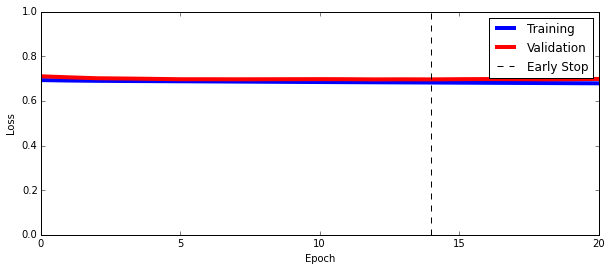

In [11]:
print_loss(model)

Train and test on the multi-filter model used in the tutorial.

In [12]:
multi_filter_model = models.SequenceDNN(
    seq_length=X_train.shape[3],
    num_filters=[15],
    conv_width=[45],
    pool_width=45,
    dropout=0.1
)

In [13]:
multi_filter_model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Loss: 0.7153	Balanced Accuracy: 50.37%	 auROC: 0.516	 auPRC: 0.501	 auPRG: 0.023
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1066	 Num Negatives: 1084
Valid Loss: 0.7297	Balanced Accuracy: 40.70%	 auROC: 0.443	 auPRC: 0.558	 auPRG: -0.064
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 59	 Num Negatives: 41 *
Epoch 2:
Train Loss: 0.7077	Balanced Accuracy: 52.89%	 auROC: 0.542	 auPRC: 0.523	 auPRG: 0.067
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1066	 Num Negatives: 1084
Valid Loss: 0.7189	Balanced Accuracy: 45.51%	 auROC: 0.448	 auPRC: 0.555	 auPRG: -0.048
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 59	 Num Negatives: 41 *
Epoch 3:
Train Loss: 0.6922	Balanced Accuracy: 54.69%	 auROC: 0.571	 auPRC: 0.549	 auPRG: 0.130
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1066	 Num Negatives: 1084
Valid Loss: 0.7495	Balanced Accuracy: 48.55%	 auROC: 0.449	 auPRC: 0.554

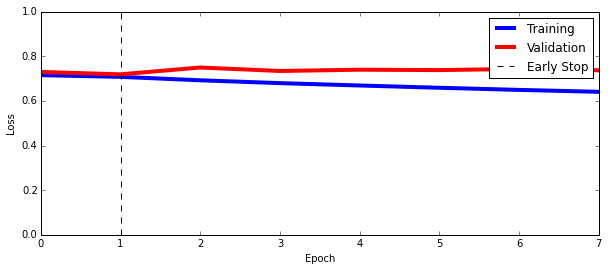

In [14]:
print_loss(multi_filter_model)